# 提案手法の実験（ラベルが適切か出力）

## マルチサイズ
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

import csv

import numpy as np
import pandas as pd
import pickle
import copy
import cv2
import random
import glob

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback
# from tf.keras.utils import multi_gpu_model


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


In [3]:
# Define
max_size = 100
encord_size = int(max_size / 2)

NOTEBOOK_NAME = 'wafermap_multisize_train_validation'
cnn_path = './model/cnn_' + str(max_size) + '_' + NOTEBOOK_NAME + '.h5'

epoch = 30
batch_size = 2048

In [4]:
faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

### データの読み出し

- train

In [5]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/train/' + '*.npy'))
TRAINS = ['./data/multi_' + str(max_size) + '/train/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/train/y.pickle')
new_y = to_categorical(y)
# split test

# shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
# TRAINS = [TRAINS[i] for i in shuffle_indices]
# new_y = new_y[shuffle_indices]

x_train = TRAINS
y_train = new_y

- validaiton

In [6]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/validation/' + '*.npy'))
VALIDATIONS = ['./data/multi_' + str(max_size) + '/validation/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/validation/y.pickle')
new_y = to_categorical(y)
# split test

# shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
# TRAINS = [TRAINS[i] for i in shuffle_indices]
# new_y = new_y[shuffle_indices]

x_validation = VALIDATIONS
y_validation = new_y

In [7]:
# batchを取得する関数
from multiprocessing import Pool
import time

def load_array(file):
    return np.load(file)

def get_batch(batch_size): 
    global x_train, y_train
    SIZE = len(x_train)
    # n_batchs
    n_batchs = SIZE//batch_size + 1
    # for でyield
    i = 0
    start = time.time()
    while (i < n_batchs):
        print("doing", i, "/", n_batchs)
        Y_batch = y_train[(i * batch_size):((i + 1) * batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        X_batch_name = x_train[(i * batch_size):((i + 1) * batch_size)]

        # filenameにしたがってバッチのtensorを構築
        with Pool() as p:
            arr = p.map(load_array, X_batch_name)
            
        X_batch = np.array(arr).reshape(len(X_batch_name), max_size, max_size, 3)
#         X_batch = np.array([np.load(file)
#                             for file in X_batch_name]).reshape(len(X_batch_name), max_size, max_size, 3)
        i += 1
        print('elapsed time', time.time()-start)
        yield X_batch, Y_batch

- 学習データとテストデータに分割する．

In [8]:
print('Train x : {}, y : {}'.format(len(x_train), y_train.shape))
print('Validation x: {}, y : {}'.format(len(x_validation), y_validation.shape))

Train x : 296993, y : (296993, 9)
Validation x: 4500, y : (4500, 9)


In [9]:
print("loading X_validation...")
with Pool() as p:
    arr = p.map(load_array, x_validation)

x_validation = np.array(arr).reshape(len(x_validation), max_size, max_size, 3)

loading X_validation...


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [10]:
def create_model():
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)

        conv_1 = layers.Conv2D(8, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(conv_1)
        conv_3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_2)

        flat = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(64, activation='relu')(flat)
        dense_2 = layers.Dense(32, activation='relu')(dense_1)
        output_tensor = layers.Dense(9, activation='softmax')(dense_2)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [11]:
# model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# # 3-Fold Crossvalidation
# kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
# # results = cross_val_score(model, x_train, y_train, cv=kfold)
# # # Check 3-fold model's mean accuracy
# # print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [12]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "device:XLA_GPU:0"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:XLA_GPU:0')
Number of devices: 3


In [13]:
epoch=5
batch_size=1024
random.seed(1)

In [25]:
# model = create_model()
# epoch_train_loss = []
# epoch_train_acc = []
# epoch_validation_loss = []
# epoch_validation_acc = []
for ep in range(epoch):
    print("=" * 50)
    print(ep, "/", epoch)
    step_loss = []
    step_acc = []
    
    # batch_size=1000でHDDからバッチを取得する
    for X_batch, Y_batch in get_batch(batch_size):
        model.train_on_batch(X_batch, Y_batch)
        score = model.evaluate(X_batch, Y_batch)
        print("batch loss:", score[0])
        print("batch accuracy:", score[1])
        step_loss.append(score[0])
        step_acc.append(score[1])
    print("Train loss", np.mean(step_loss))
    print("Train accuracy", np.mean(step_acc))
    score = model.evaluate(x_validation, y_validation)
    print("Validation loss:", score[0])
    print("Validation accuracy:", score[1])
    epoch_train_loss.append(np.mean(step_loss))
    epoch_train_acc.append(np.mean(step_acc))
    epoch_validation_loss.append(score[0])
    epoch_validation_acc.append(score[1])
    
    shuffle_indices = random.sample(list(range(len(x_train))), len(x_train))
    x_train = [x_train[i] for i in shuffle_indices]
    y_train = y_train[shuffle_indices]
    
    model.save(cnn_path)

0 / 5
doing 0 / 291
elapsed time 125.40386772155762
32/32 [==============================] - 0s 4ms/step - loss: 0.0168 - accuracy: 0.9971
batch loss: 0.016785230487585068
batch accuracy: 0.9970703125
doing 1 / 291
elapsed time 244.12810635566711
32/32 [==============================] - 0s 5ms/step - loss: 0.0201 - accuracy: 0.9980
batch loss: 0.020062480121850967
batch accuracy: 0.998046875
doing 2 / 291
elapsed time 369.28113865852356
32/32 [==============================] - 0s 5ms/step - loss: 0.0206 - accuracy: 0.9980
batch loss: 0.020620662719011307
batch accuracy: 0.998046875
doing 3 / 291
elapsed time 486.5176889896393
32/32 [==============================] - 0s 4ms/step - loss: 0.0257 - accuracy: 0.9961
batch loss: 0.025748014450073242
batch accuracy: 0.99609375
doing 4 / 291
elapsed time 611.5808672904968
32/32 [==============================] - 0s 4ms/step - loss: 0.0229 - accuracy: 0.9941
batch loss: 0.022912021726369858
batch accuracy: 0.994140625
doing 5 / 291
elapsed time

elapsed time 5309.626695394516
32/32 [==============================] - 0s 5ms/step - loss: 0.0134 - accuracy: 0.9971
batch loss: 0.013364054262638092
batch accuracy: 0.9970703125
doing 43 / 291
elapsed time 5451.723969221115
32/32 [==============================] - 0s 5ms/step - loss: 0.0102 - accuracy: 1.0000
batch loss: 0.010175518691539764
batch accuracy: 1.0
doing 44 / 291
elapsed time 5575.43655705452
32/32 [==============================] - 0s 5ms/step - loss: 0.0159 - accuracy: 0.9961
batch loss: 0.015851449221372604
batch accuracy: 0.99609375
doing 45 / 291
elapsed time 5702.554989337921
32/32 [==============================] - 0s 4ms/step - loss: 0.0127 - accuracy: 0.9980
batch loss: 0.01273126620799303
batch accuracy: 0.998046875
doing 46 / 291
elapsed time 5839.397887706757
32/32 [==============================] - 0s 4ms/step - loss: 0.0198 - accuracy: 0.9951
batch loss: 0.019806930795311928
batch accuracy: 0.9951171875
doing 47 / 291
elapsed time 5973.836897611618
32/32 [=

32/32 [==============================] - 0s 4ms/step - loss: 0.0119 - accuracy: 0.9980
batch loss: 0.011883866041898727
batch accuracy: 0.998046875
doing 127 / 291
elapsed time 13179.70748090744
32/32 [==============================] - 0s 5ms/step - loss: 0.0196 - accuracy: 0.9980
batch loss: 0.019583219662308693
batch accuracy: 0.998046875
doing 128 / 291
elapsed time 13262.714722633362
32/32 [==============================] - 0s 5ms/step - loss: 0.0085 - accuracy: 0.9980
batch loss: 0.008546644821763039
batch accuracy: 0.998046875
doing 129 / 291
elapsed time 13347.876908540726
32/32 [==============================] - 0s 4ms/step - loss: 0.0087 - accuracy: 1.0000
batch loss: 0.008719254285097122
batch accuracy: 1.0
doing 130 / 291
elapsed time 13434.819469928741
32/32 [==============================] - 0s 4ms/step - loss: 0.0080 - accuracy: 1.0000
batch loss: 0.007962859235703945
batch accuracy: 1.0
doing 131 / 291
elapsed time 13520.319859981537
32/32 [==============================

32/32 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 0.9990
batch loss: 0.010905619710683823
batch accuracy: 0.9990234375
doing 211 / 291
elapsed time 20640.32648873329
32/32 [==============================] - 0s 5ms/step - loss: 0.0152 - accuracy: 0.9961
batch loss: 0.0151570625603199
batch accuracy: 0.99609375
doing 212 / 291
elapsed time 20727.585088014603
32/32 [==============================] - 0s 4ms/step - loss: 0.0146 - accuracy: 0.9980
batch loss: 0.014572776854038239
batch accuracy: 0.998046875
doing 213 / 291
elapsed time 20818.18301844597
32/32 [==============================] - 0s 4ms/step - loss: 0.0125 - accuracy: 0.9980
batch loss: 0.012539735063910484
batch accuracy: 0.998046875
doing 214 / 291
elapsed time 20904.79783654213
32/32 [==============================] - 0s 4ms/step - loss: 0.0141 - accuracy: 0.9971
batch loss: 0.014098829589784145
batch accuracy: 0.9970703125
doing 215 / 291
elapsed time 20991.661830425262
32/32 [=================

32/32 [==============================] - 0s 5ms/step - loss: 0.0182 - accuracy: 0.9961
batch loss: 0.01821225881576538
batch accuracy: 0.99609375
doing 253 / 291
elapsed time 24485.4326338768
32/32 [==============================] - 0s 4ms/step - loss: 0.0152 - accuracy: 0.9961
batch loss: 0.015168262645602226
batch accuracy: 0.99609375
doing 254 / 291
elapsed time 24577.83527779579
32/32 [==============================] - 0s 4ms/step - loss: 0.0106 - accuracy: 0.9980
batch loss: 0.010589074343442917
batch accuracy: 0.998046875
doing 255 / 291
elapsed time 24669.73304915428
32/32 [==============================] - 0s 4ms/step - loss: 0.0175 - accuracy: 0.9932
batch loss: 0.01750069111585617
batch accuracy: 0.9931640625
doing 256 / 291
elapsed time 24759.027610063553
32/32 [==============================] - 0s 4ms/step - loss: 0.0092 - accuracy: 0.9980
batch loss: 0.00920011755079031
batch accuracy: 0.998046875
doing 257 / 291
elapsed time 24852.35159420967
32/32 [======================

elapsed time 194.68538975715637
32/32 [==============================] - 0s 4ms/step - loss: 0.0063 - accuracy: 0.9990
batch loss: 0.006292153149843216
batch accuracy: 0.9990234375
doing 3 / 291
elapsed time 258.63696098327637
32/32 [==============================] - 0s 5ms/step - loss: 0.0064 - accuracy: 1.0000
batch loss: 0.006446056067943573
batch accuracy: 1.0
doing 4 / 291
elapsed time 327.39063334465027
32/32 [==============================] - 0s 4ms/step - loss: 0.0070 - accuracy: 1.0000
batch loss: 0.007027476094663143
batch accuracy: 1.0
doing 5 / 291
elapsed time 394.9944121837616
32/32 [==============================] - 0s 4ms/step - loss: 0.0055 - accuracy: 1.0000
batch loss: 0.00549865560606122
batch accuracy: 1.0
doing 6 / 291
elapsed time 463.02724719047546
32/32 [==============================] - 0s 4ms/step - loss: 0.0055 - accuracy: 1.0000
batch loss: 0.005493678152561188
batch accuracy: 1.0
doing 7 / 291
elapsed time 532.3282375335693
32/32 [=========================

elapsed time 3210.7139644622803
32/32 [==============================] - 0s 4ms/step - loss: 0.0073 - accuracy: 0.9971
batch loss: 0.007328297942876816
batch accuracy: 0.9970703125
doing 46 / 291
elapsed time 3298.7983679771423
32/32 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 0.9990
batch loss: 0.009444333612918854
batch accuracy: 0.9990234375
doing 47 / 291
elapsed time 3383.979659318924
32/32 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 0.9990
batch loss: 0.005225994624197483
batch accuracy: 0.9990234375
doing 48 / 291
elapsed time 3471.9621617794037
32/32 [==============================] - 0s 4ms/step - loss: 0.0062 - accuracy: 0.9990
batch loss: 0.006164433900266886
batch accuracy: 0.9990234375
doing 49 / 291
elapsed time 3560.7963304519653
32/32 [==============================] - 0s 4ms/step - loss: 0.0067 - accuracy: 0.9990
batch loss: 0.006683727726340294
batch accuracy: 0.9990234375
doing 50 / 291
elapsed time 3646.754

elapsed time 7283.957921504974
32/32 [==============================] - 0s 5ms/step - loss: 0.0060 - accuracy: 0.9990
batch loss: 0.006010449957102537
batch accuracy: 0.9990234375
doing 89 / 291
elapsed time 7387.957194805145
32/32 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 0.9990
batch loss: 0.0044528101570904255
batch accuracy: 0.9990234375
doing 90 / 291
elapsed time 7485.16442322731
32/32 [==============================] - 0s 4ms/step - loss: 0.0110 - accuracy: 0.9980
batch loss: 0.011013706214725971
batch accuracy: 0.998046875
doing 91 / 291
elapsed time 7588.863197803497
32/32 [==============================] - 0s 4ms/step - loss: 0.0063 - accuracy: 0.9990
batch loss: 0.006283254828304052
batch accuracy: 0.9990234375
doing 92 / 291
elapsed time 7691.5716671943665
32/32 [==============================] - 0s 5ms/step - loss: 0.0095 - accuracy: 0.9990
batch loss: 0.009538100101053715
batch accuracy: 0.9990234375
doing 93 / 291
elapsed time 7787.8532702

32/32 [==============================] - 0s 4ms/step - loss: 0.0118 - accuracy: 0.9961
batch loss: 0.011787009425461292
batch accuracy: 0.99609375
doing 173 / 291
elapsed time 14011.805733680725
32/32 [==============================] - 0s 4ms/step - loss: 0.0101 - accuracy: 0.9961
batch loss: 0.010096633806824684
batch accuracy: 0.99609375
doing 174 / 291
elapsed time 14089.722388029099
32/32 [==============================] - 0s 6ms/step - loss: 0.0115 - accuracy: 0.9980
batch loss: 0.011485014110803604
batch accuracy: 0.998046875
doing 175 / 291
elapsed time 14165.926087379456
32/32 [==============================] - 0s 4ms/step - loss: 0.0072 - accuracy: 0.9990
batch loss: 0.0071967365220189095
batch accuracy: 0.9990234375
doing 176 / 291
elapsed time 14241.109461307526
32/32 [==============================] - 0s 4ms/step - loss: 0.0078 - accuracy: 0.9990
batch loss: 0.007776079699397087
batch accuracy: 0.9990234375
doing 177 / 291
elapsed time 14315.636355161667
32/32 [============

32/32 [==============================] - 0s 4ms/step - loss: 0.0055 - accuracy: 1.0000
batch loss: 0.005498986225575209
batch accuracy: 1.0
doing 257 / 291
elapsed time 20539.13473200798
32/32 [==============================] - 0s 4ms/step - loss: 0.0067 - accuracy: 0.9990
batch loss: 0.00670494744554162
batch accuracy: 0.9990234375
doing 258 / 291
elapsed time 20615.743827581406
32/32 [==============================] - 0s 4ms/step - loss: 0.0078 - accuracy: 0.9990
batch loss: 0.0078078582882881165
batch accuracy: 0.9990234375
doing 259 / 291
elapsed time 20694.999618291855
32/32 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 0.9990
batch loss: 0.006428120192140341
batch accuracy: 0.9990234375
doing 260 / 291
elapsed time 20772.98767209053
32/32 [==============================] - 0s 4ms/step - loss: 0.0152 - accuracy: 0.9961
batch loss: 0.015240006148815155
batch accuracy: 0.99609375
doing 261 / 291
elapsed time 20852.22092103958
32/32 [======================

32/32 [==============================] - 0s 5ms/step - loss: 0.0049 - accuracy: 1.0000
batch loss: 0.0048623341135680676
batch accuracy: 1.0
doing 7 / 291
elapsed time 306.6662402153015
32/32 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 1.0000
batch loss: 0.004002416040748358
batch accuracy: 1.0
doing 8 / 291
elapsed time 346.1102077960968
32/32 [==============================] - 0s 4ms/step - loss: 0.0050 - accuracy: 0.9990
batch loss: 0.0050322143360972404
batch accuracy: 0.9990234375
doing 9 / 291
elapsed time 383.5871889591217
32/32 [==============================] - 0s 5ms/step - loss: 0.0038 - accuracy: 1.0000
batch loss: 0.0038487326819449663
batch accuracy: 1.0
doing 10 / 291
elapsed time 421.48721837997437
32/32 [==============================] - 0s 4ms/step - loss: 0.0054 - accuracy: 1.0000
batch loss: 0.005395432468503714
batch accuracy: 1.0
doing 11 / 291
elapsed time 459.87158489227295
32/32 [==============================] - 0s 5ms/step - loss

32/32 [==============================] - 0s 5ms/step - loss: 0.0044 - accuracy: 1.0000
batch loss: 0.004448132589459419
batch accuracy: 1.0
doing 93 / 291
elapsed time 4305.325657606125
32/32 [==============================] - 0s 5ms/step - loss: 0.0039 - accuracy: 1.0000
batch loss: 0.00389481196179986
batch accuracy: 1.0
doing 94 / 291
elapsed time 4368.692806720734
32/32 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 1.0000
batch loss: 0.003819661680608988
batch accuracy: 1.0
doing 95 / 291
elapsed time 4431.576910495758
32/32 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 1.0000
batch loss: 0.004405425861477852
batch accuracy: 1.0
doing 96 / 291
elapsed time 4495.618722200394
32/32 [==============================] - 0s 5ms/step - loss: 0.0057 - accuracy: 0.9990
batch loss: 0.0056505361571908
batch accuracy: 0.9990234375
doing 97 / 291
elapsed time 4555.2376754283905
32/32 [==============================] - 0s 4ms/step - loss: 0.

32/32 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 1.0000
batch loss: 0.0037795938551425934
batch accuracy: 1.0
doing 136 / 291
elapsed time 7404.491505622864
32/32 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 1.0000
batch loss: 0.0023532570339739323
batch accuracy: 1.0
doing 137 / 291
elapsed time 7482.67923784256
32/32 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 1.0000
batch loss: 0.0032391564454883337
batch accuracy: 1.0
doing 138 / 291
elapsed time 7557.379023075104
32/32 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 0.9980
batch loss: 0.009369993582367897
batch accuracy: 0.998046875
doing 139 / 291
elapsed time 7636.487626791
32/32 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 1.0000
batch loss: 0.002812066115438938
batch accuracy: 1.0
doing 140 / 291
elapsed time 7715.820611000061
32/32 [==============================] - 0s 4ms/step - los

elapsed time 10682.174149036407
32/32 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.9990
batch loss: 0.0033643413335084915
batch accuracy: 0.9990234375
doing 179 / 291
elapsed time 10763.90272808075
32/32 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 1.0000
batch loss: 0.003276103176176548
batch accuracy: 1.0
doing 180 / 291
elapsed time 10844.011433839798
32/32 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 1.0000
batch loss: 0.003872110042721033
batch accuracy: 1.0
doing 181 / 291
elapsed time 10923.743601322174
32/32 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 0.9990
batch loss: 0.004486908204853535
batch accuracy: 0.9990234375
doing 182 / 291
elapsed time 11005.693364620209
32/32 [==============================] - 0s 4ms/step - loss: 0.0080 - accuracy: 0.9980
batch loss: 0.007992907427251339
batch accuracy: 0.998046875
doing 183 / 291
elapsed time 11088.932710647583
32

32/32 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 1.0000
batch loss: 0.0032200838904827833
batch accuracy: 1.0
doing 264 / 291
elapsed time 17540.1219997406
32/32 [==============================] - 0s 5ms/step - loss: 0.0059 - accuracy: 0.9980
batch loss: 0.005888328421860933
batch accuracy: 0.998046875
doing 265 / 291
elapsed time 17619.350049972534
32/32 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 1.0000
batch loss: 0.004008989781141281
batch accuracy: 1.0
doing 266 / 291
elapsed time 17699.904747247696
32/32 [==============================] - 0s 4ms/step - loss: 0.0119 - accuracy: 0.9971
batch loss: 0.011948695406317711
batch accuracy: 0.9970703125
doing 267 / 291
elapsed time 17782.03853034973
32/32 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 1.0000
batch loss: 0.003358990652486682
batch accuracy: 1.0
doing 268 / 291
elapsed time 17863.53765964508
32/32 [==============================] - 0s 4m

elapsed time 3592.769460916519
32/32 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 1.0000
batch loss: 0.0018957946449518204
batch accuracy: 1.0
doing 58 / 291
elapsed time 3686.2029542922974
32/32 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 1.0000
batch loss: 0.0012366143055260181
batch accuracy: 1.0
doing 59 / 291
elapsed time 3776.5696127414703
32/32 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 1.0000
batch loss: 0.0019256845116615295
batch accuracy: 1.0
doing 60 / 291
elapsed time 3860.520961999893
32/32 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 1.0000
batch loss: 0.001736803911626339
batch accuracy: 1.0
doing 61 / 291
elapsed time 3947.0973007678986
32/32 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 1.0000
batch loss: 0.0024672728031873703
batch accuracy: 1.0
doing 62 / 291
elapsed time 4033.515110015869
32/32 [=========================

32/32 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9883
batch loss: 0.05236516892910004
batch accuracy: 0.98828125
doing 143 / 291
elapsed time 14212.771812438965
32/32 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 0.9863
batch loss: 0.0348653607070446
batch accuracy: 0.986328125
doing 144 / 291
elapsed time 14362.865790843964
32/32 [==============================] - 0s 4ms/step - loss: 0.0317 - accuracy: 0.9941
batch loss: 0.03165915235877037
batch accuracy: 0.994140625
doing 145 / 291
elapsed time 14518.364914894104
32/32 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9951
batch loss: 0.02158736065030098
batch accuracy: 0.9951171875
doing 146 / 291
elapsed time 14667.956662416458
32/32 [==============================] - 0s 4ms/step - loss: 0.0264 - accuracy: 0.9932
batch loss: 0.0264064222574234
batch accuracy: 0.9931640625
doing 147 / 291
elapsed time 14832.094696760178
32/32 [===================

elapsed time 24948.143361091614
32/32 [==============================] - 0s 4ms/step - loss: 0.0046 - accuracy: 1.0000
batch loss: 0.004582335241138935
batch accuracy: 1.0
doing 228 / 291
elapsed time 25050.177313804626
32/32 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 0.9990
batch loss: 0.004382693208754063
batch accuracy: 0.9990234375
doing 229 / 291
elapsed time 25152.56917500496
32/32 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 0.9990
batch loss: 0.0038605770096182823
batch accuracy: 0.9990234375
doing 230 / 291
elapsed time 25260.09503674507
32/32 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 1.0000
batch loss: 0.004398428834974766
batch accuracy: 1.0
doing 231 / 291
elapsed time 25363.796778440475
32/32 [==============================] - 0s 5ms/step - loss: 0.0049 - accuracy: 0.9990
batch loss: 0.004904585890471935
batch accuracy: 0.9990234375
doing 232 / 291
elapsed time 25467.976559638977
32

elapsed time 29647.643122434616
32/32 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 1.0000
batch loss: 0.002803601324558258
batch accuracy: 1.0
doing 271 / 291
elapsed time 29746.666246175766
32/32 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 1.0000
batch loss: 0.00253051845356822
batch accuracy: 1.0
doing 272 / 291
elapsed time 29843.821642160416
32/32 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000
batch loss: 0.0017524712020531297
batch accuracy: 1.0
doing 273 / 291
elapsed time 29940.936698436737
32/32 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 1.0000
batch loss: 0.002204136224463582
batch accuracy: 1.0
doing 274 / 291
elapsed time 30040.08496284485
32/32 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 1.0000
batch loss: 0.0029492967296391726
batch accuracy: 1.0
doing 275 / 291
elapsed time 30138.089821338654
32/32 [=====================

32/32 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 1.0000
batch loss: 0.0037676719948649406
batch accuracy: 1.0
doing 22 / 291
elapsed time 2403.573315382004
32/32 [==============================] - 0s 4ms/step - loss: 0.0052 - accuracy: 0.9990
batch loss: 0.005182255990803242
batch accuracy: 0.9990234375
doing 23 / 291
elapsed time 2521.723771095276
32/32 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000
batch loss: 0.001634787768125534
batch accuracy: 1.0
doing 24 / 291
elapsed time 2640.054066181183
32/32 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 1.0000
batch loss: 0.0025489251129329205
batch accuracy: 1.0
doing 25 / 291
elapsed time 2757.3690321445465
32/32 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 1.0000
batch loss: 0.0026694622356444597
batch accuracy: 1.0
doing 26 / 291
elapsed time 2873.0004749298096
32/32 [==============================] - 0s 4ms/step - l

elapsed time 7024.757811307907
32/32 [==============================] - 0s 4ms/step - loss: 0.0575 - accuracy: 0.9785
batch loss: 0.05754875764250755
batch accuracy: 0.978515625
doing 65 / 291
elapsed time 7137.345966100693
32/32 [==============================] - 0s 4ms/step - loss: 0.0502 - accuracy: 0.9814
batch loss: 0.05022026225924492
batch accuracy: 0.9814453125
doing 66 / 291
elapsed time 7251.835193395615
32/32 [==============================] - 0s 4ms/step - loss: 0.0287 - accuracy: 0.9912
batch loss: 0.028748195618391037
batch accuracy: 0.9912109375
doing 67 / 291
elapsed time 7365.090368032455
32/32 [==============================] - 0s 5ms/step - loss: 0.0690 - accuracy: 0.9736
batch loss: 0.06900633126497269
batch accuracy: 0.9736328125
doing 68 / 291
elapsed time 7475.597012042999
32/32 [==============================] - 0s 5ms/step - loss: 0.0507 - accuracy: 0.9844
batch loss: 0.05067574977874756
batch accuracy: 0.984375
doing 69 / 291
elapsed time 7590.187710762024
32/

elapsed time 16643.027719020844
32/32 [==============================] - 0s 4ms/step - loss: 0.0043 - accuracy: 0.9990
batch loss: 0.004324925597757101
batch accuracy: 0.9990234375
doing 150 / 291
elapsed time 16754.638875246048
32/32 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 1.0000
batch loss: 0.0038441079668700695
batch accuracy: 1.0
doing 151 / 291
elapsed time 16862.125993013382
32/32 [==============================] - 0s 4ms/step - loss: 0.0085 - accuracy: 0.9980
batch loss: 0.008536030538380146
batch accuracy: 0.998046875
doing 152 / 291
elapsed time 16969.844123601913
32/32 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 0.9990
batch loss: 0.0033306858967989683
batch accuracy: 0.9990234375
doing 153 / 291
elapsed time 17080.773540258408
32/32 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 0.9990
batch loss: 0.003793169744312763
batch accuracy: 0.9990234375
doing 154 / 291
elapsed time 17187.4464

32/32 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 1.0000
batch loss: 0.003587996819987893
batch accuracy: 1.0
doing 193 / 291
elapsed time 21583.284848213196
32/32 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 1.0000
batch loss: 0.0025848294608294964
batch accuracy: 1.0
doing 194 / 291
elapsed time 21699.664943933487
32/32 [==============================] - 0s 4ms/step - loss: 0.0046 - accuracy: 0.9990
batch loss: 0.004583612084388733
batch accuracy: 0.9990234375
doing 195 / 291
elapsed time 21814.073044776917
32/32 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 1.0000
batch loss: 0.002776001114398241
batch accuracy: 1.0
doing 196 / 291
elapsed time 21925.42171382904
32/32 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 1.0000
batch loss: 0.0026357080787420273
batch accuracy: 1.0
doing 197 / 291
elapsed time 22038.09751534462
32/32 [==============================] - 0s 4ms/ste

32/32 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 1.0000
batch loss: 0.0028642723336815834
batch accuracy: 1.0
doing 279 / 291
elapsed time 30999.976235628128
32/32 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 1.0000
batch loss: 0.0013691239291802049
batch accuracy: 1.0
doing 280 / 291
elapsed time 31109.719552993774
32/32 [==============================] - 0s 5ms/step - loss: 0.0023 - accuracy: 1.0000
batch loss: 0.002336320001631975
batch accuracy: 1.0
doing 281 / 291
elapsed time 31219.962062120438
32/32 [==============================] - 0s 4ms/step - loss: 0.0031 - accuracy: 0.9990
batch loss: 0.0031455587595701218
batch accuracy: 0.9990234375
doing 282 / 291
elapsed time 31327.999744176865
32/32 [==============================] - 0s 4ms/step - loss: 0.0022 - accuracy: 1.0000
batch loss: 0.0021973634138703346
batch accuracy: 1.0
doing 283 / 291
elapsed time 31441.12079834938
32/32 [==============================] - 0s 4ms/

In [26]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|       ImageDataGenerator|      1064|
|                       In|       352|
|                    Input|       144|
|                    KFold|      1064|
|          KerasClassifier|      1064|
|            NOTEBOOK_NAME|        84|
|                      Out|       248|
|                     Pool|        72|
|                   TRAINS|   2380496|
|              VALIDATIONS|     38224|
|                  X_batch|       144|
|                  Y_batch|       112|
|                      arr|     36072|
|               batch_size|        28|
|               cnf_matrix|       760|
|                 cnn_path|       103|
|         confusion_matrix|       144|
|                     copy|        88|
|             create_model|       144|
|          cross_val_score|       144|
|                      csv|        88|
|                      cv2|        88|
|                data_size|        28|
|                 datapat

### テストデータで評価

In [27]:
x_test = joblib.load('./data/multi_' + str(max_size) + '/test/xtest.pickle')
y_test = joblib.load('./data/multi_' + str(max_size) + '/test/ytest.pickle')
y_test = to_categorical(y_test)

In [28]:
score = model.evaluate(x_test, y_test)
# score = model.evaluate(x_validation, y_validation)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
testscore = score[1]
trainscore = epoch_train_acc[-1]
valiscore = epoch_validation_acc[-1]
print("Train accuracy:", trainscore)
print("Validation accuracy:", valiscore)
print("Test accuracy:", testscore)

15/15 [==============================] - 0s 5ms/step - loss: 2.3243 - accuracy: 0.7889
Test loss: 2.324291467666626
Test accuracy: 0.7888888716697693
Train accuracy: 0.9974830863402062
Validation accuracy: 0.9197777509689331
Test accuracy: 0.7888888716697693


In [29]:
y_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
np.sum(y_test_max == y_predict, axis=0, dtype='float') / x_test.shape[0]

0.7888888888888889

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
flatten (Flatten)            (None, 320000)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                20480064  
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

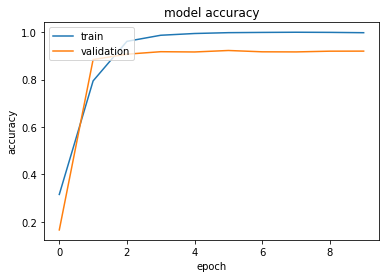

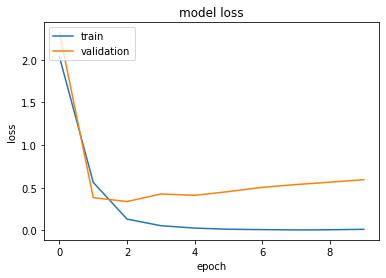

In [31]:
# accuracy plot
fig1 = plt.figure()
plt.plot(epoch_train_acc)
plt.plot(epoch_validation_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig1.savefig("multisize_accuracy.png")

# loss plot
fig2 = plt.figure()
plt.plot(epoch_train_loss)
plt.plot(epoch_validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig2.savefig("multisize_loss.png")

### 混同行列

In [32]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- validation confmat

Confusion matrix, without normalization
Normalized confusion matrix


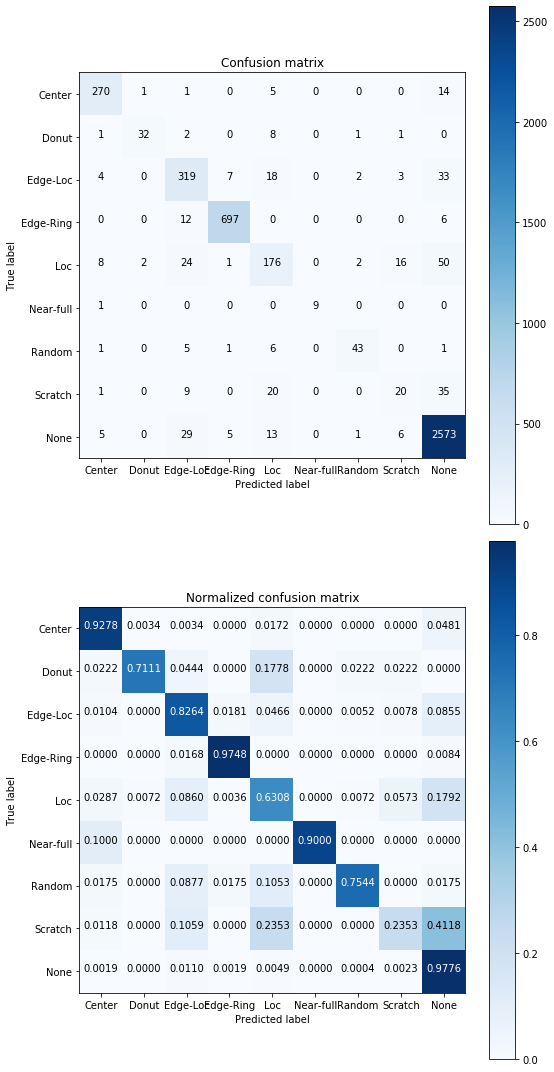

In [33]:
# Compute confusion matrix
y_validation_predict = np.argmax(model.predict(x_validation), axis=1)
y_validation_max = np.argmax(y_validation, axis=1)
cnf_matrix = confusion_matrix(y_validation_max, y_validation_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_valiconfmat.png")

- test confmat

Confusion matrix, without normalization
Normalized confusion matrix


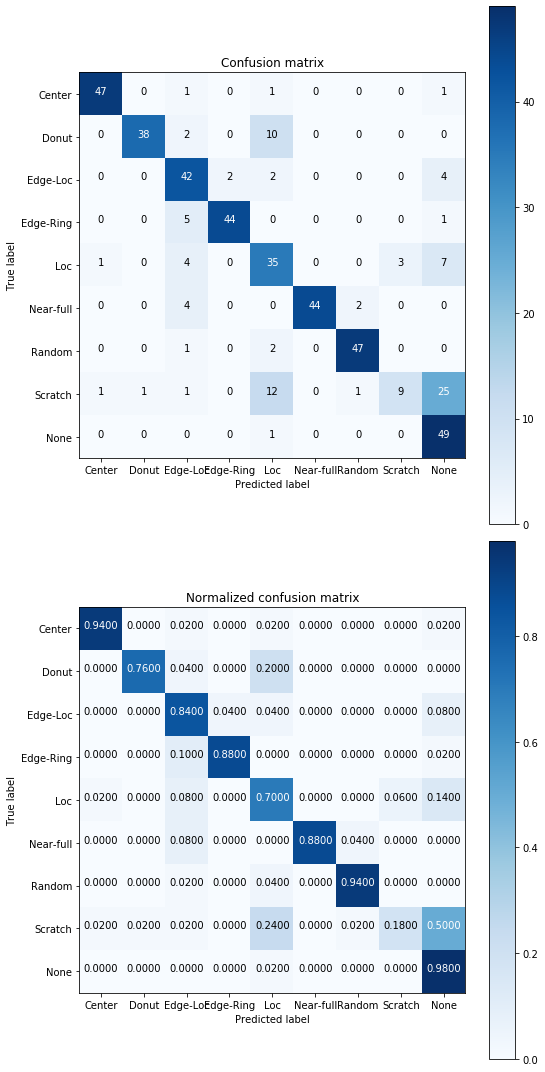

In [34]:
# Compute confusion matrix
y_test_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(y_test_max, y_test_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_testconfmat.png")

In [35]:
import requests

# LINEの設定
path = './lineapi.txt'
with open(path) as f:
    s = f.read()
    line_token = s.rstrip('\n')

# LINEに通知する関数
def line_notify(text):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, headers=headers)#, proxies=proxies)

# LINEに画像を送る関数
def line_notify_img(text, imgpath):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text, "notificationDisabled": True}
    files = {"imageFile": open(imgpath, "rb")}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, files=files, headers=headers)#, proxies=proxies)
    
line_notify("学習が終了しました ")
# line_notify("Shawon: " + str(shawon) + ", rotation_num: " + str(rotation_num) + ", inversion: " + str(inversion) + ", trials: " + str(trials))
line_notify_img("正解率", "multisize_accuracy.png")
line_notify_img("Loss", "multisize_loss.png")
line_notify_img("validation混同行列", "multisize_valiconfmat.png")
line_notify_img("test混同行列", "multisize_testconfmat.png")
line_notify("train:" + str(trainscore) + "\nvali:" + str(valiscore) + "\ntest:" + str(testscore))

ConnectionError: HTTPSConnectionPool(host='notify-api.line.me', port=443): Max retries exceeded with url: /api/notify (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f493399a310>: Failed to establish a new connection: [Errno 110] Connection timed out'))